# Set Up

Imports

In [34]:
import tensorflow as tf
from tensorflow.keras import layers

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

import json
import numpy as np

Set up Cloud Directories

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
project_folder_path = '/content/drive/MyDrive/CSC5218_Project_DL'
models_folder_path = os.path.join(project_folder_path, "saved models")
data_folder_path = os.path.join(project_folder_path, "data")
results_folder_path = os.path.join(project_folder_path, "results")

Unzip raw data in colab's vm

In [4]:
raw_data_path = os.path.join(data_folder_path, 'raw', 'dataset.zip')
print(raw_data_path)

/content/drive/MyDrive/CSC5218_Project_DL/data/raw/dataset.zip


In [ ]:
!unzip $raw_data_path

Set up the dataset

In [6]:
batch_size = 32
image_height = 512
image_width = 512
dataset_path = 'dataset'

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 3064 files belonging to 3 classes.
Using 2452 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 3064 files belonging to 3 classes.
Using 612 files for validation.


Create Test Dataset from Validation

In [9]:
val_batches = tf.data.experimental.cardinality(val_ds)

# Create test set from validation set

test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print(tf.data.experimental.cardinality(test_ds))
print(tf.data.experimental.cardinality(val_ds))

tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)


Looking at the data



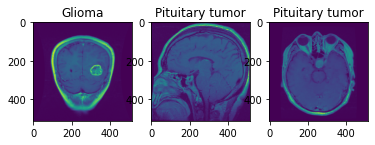

In [10]:
fig, axs = plt.subplots(1,3)

image_batch = next(iter(train_ds)) # Grab a batch
for i in range(3):
  image = np.array(image_batch[0])[i] # Grab ith image
  label = np.array(image_batch[1])[i] # Grab ith label
  label_name = train_ds.class_names[label] # Get label name
  # Plot
  image_as_array = np.array(image).astype(np.uint8) 
  axs[i].set_title(label_name)
  axs[i].imshow(image_as_array)

# Model Specific Set Up

Model specific paths

In [35]:
my_model_name = 'Autoencoder'
my_model_version = 1
my_model_folder_path = os.path.join(models_folder_path, 
                                    my_model_name, my_model_name+'_'+str(my_model_version))
my_model_save_path =  os.path.join(my_model_folder_path,
                                    my_model_name+'_'+str(my_model_version) + '.h5')
my_model_checkpoint_path = os.path.join(my_model_folder_path, 'checkpoints')
my_model_results_path = os.path.join(results_folder_path, my_model_name)

classifier_save_path = my_model_save_path.replace("Autoencoder_1", "Classifier_1")

print('save model to:')
print(my_model_save_path)
print('save checkpoints to:') 
print(my_model_checkpoint_path)
print('save results to:') 
print(my_model_results_path)

save model to:
/content/drive/MyDrive/CSC5218_Project_DL/saved models/Autoencoder/Autoencoder_1/Autoencoder_1.h5
save checkpoints to:
/content/drive/MyDrive/CSC5218_Project_DL/saved models/Autoencoder/Autoencoder_1/checkpoints
save results to:
/content/drive/MyDrive/CSC5218_Project_DL/results/Autoencoder


# Creating Data Sets

In [36]:
def load(image,label):
  return image/255, image/255

In [37]:
def class_load(image, label):
  return image/255, tf.one_hot(label, 3)

In [38]:
toimage_train_dataset = train_ds.map(load)
toimage_validation_dataset = val_ds.map(load)
toimage_test_dataset = test_ds.map(load)
class_train_dataset = train_ds.map(class_load)
class_validation_dataset = val_ds.map(class_load)
class_test_dataset = test_ds.map(class_load)

# Build the U-Net


*   Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
*   Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
*   There are skip connections between the encoder and decoder (as in the U-Net)

Reference: [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator)

## Downsampler (encoder)

In [39]:
def downsample(filters, size, apply_batchnorm=True, name=''):
  initializer = tf.random_normal_initializer(0., 0.02) # Define strategy for initializing tf.Variables

  result = tf.keras.Sequential(name=name)
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False)
  )

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization()) # Helps reduce training time by smoothing error space

  return result

In [40]:
inp =np.array(next(iter(train_ds))[0])[0]
print('initial image shape', inp.shape)
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(inp, 0))
print('image shape after 1 downsample', down_result.shape)

initial image shape (512, 512, 3)
image shape after 1 downsample (1, 256, 256, 3)


## Upsampler (decoder)

In [41]:
from tensorflow.python.framework.ops import name_from_scope_name
def upsample(filters, size, apply_dropout=False, name='',input=None):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential(name=name)
  if (input != None):
    result.add(
        input
    )
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False)
  )
  
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [42]:
inp =np.array(next(iter(train_ds))[0])[0]
print('initial image shape', inp.shape)
up_model = upsample(3,4)
up_result = up_model(tf.expand_dims(inp, 0))
print('image shape after 1 upsample', up_result.shape)

initial image shape (512, 512, 3)
image shape after 1 upsample (1, 1024, 1024, 3)


## Define U-Net + name layers: [ref](https://stackoverflow.com/questions/43702323/how-to-load-only-specific-weights-on-keras)

In [43]:
def UNet():
  inputs = tf.keras.layers.Input(shape=[512, 512, 3], name='input')

  down_stack = [
    downsample(64, 4, apply_batchnorm=False, name='down_1'), # (batch_size, 256, 256, 64)
    downsample(128, 4, name='down_2'), # (batch_size, 128, 128, 128)
    downsample(256, 4, name='down_3'), # (batch_size, 64, 64, 256)
    downsample(512, 4, name='down_4'), # (batch_size, 32, 32, 512)
    downsample(512, 4, name='down_5'), # (batch_size, 16, 16, 512)
    downsample(512, 4, name='down_6'), # (batch_size, 8, 8, 512)
    downsample(512, 4, name='down_7'), # (batch_size, 4, 4, 512)
    downsample(512, 4, name='down_8'), # (batch_size, 2, 2, 512)
    downsample(512, 4, name='down_9'), # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True, name='up_1'), # (batck_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True, name='up_2'), # (batck_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True, name='up_3'), # (batck_size, 8, 8, 1024)
    upsample(512, 4, name='up_4'), # (batck_size, 16, 16, 1024)
    upsample(256, 4, name='up_5'), # (batck_size, 32, 32, 512)
    upsample(128, 4, name='up_6'), # (batck_size, 64, 64, 256)
    upsample(64, 4, name='up_7'), # (batck_size, 128, 128, 128)
    upsample(32, 4, name='up_8'), # (batck_size, 256, 256, 64)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)

  last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='tanh', name='last') # (batch_size, 512, 512, 3)
  last.trainable = False

  x = inputs

  # Downsampling through the model
  l = tf.keras.layers.Conv2D(1, 1, padding='same',
                              kernel_initializer=initializer, use_bias=False, name='location')
  l.trainable = False
  l = l(x)
  for down in down_stack:
    x = down(x)
  
  layer = tf.keras.Sequential([tf.keras.layers.Dense(512)], name='latent')
  x = layer(x)

  # Upsampling and establishing the skip connection
  i = 0
  for up in up_stack:
    x = up(x)
    i += 1

  x = last(x)
  x = tf.keras.layers.Concatenate(name='concat')([x, l])
  x = tf.keras.layers.Conv2D(3, 3, name='colorer', padding='same')(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Create Generator 1

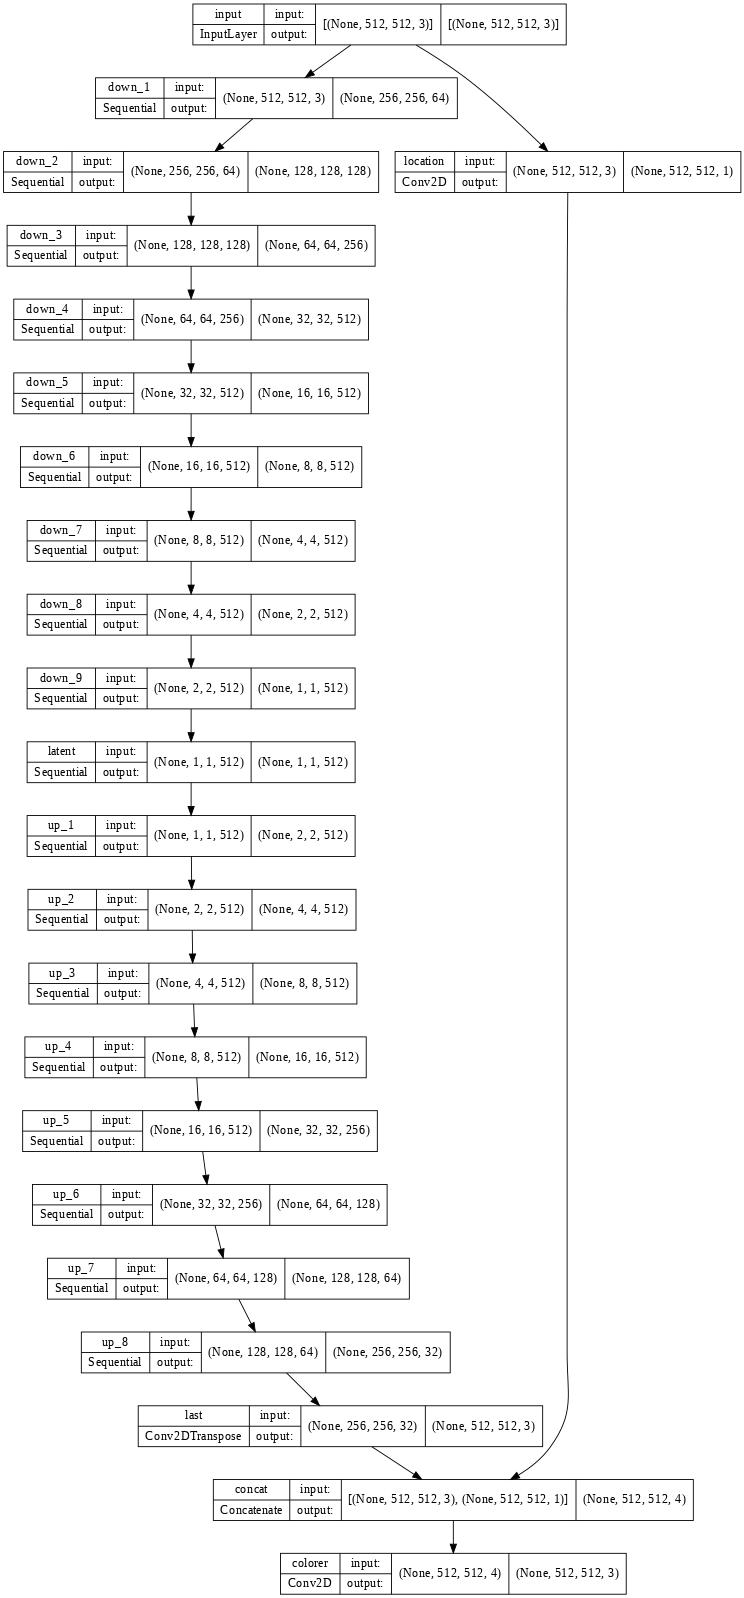

In [44]:
generator = UNet()
gen_output = generator(inp[tf.newaxis, ...], training=False)

unet_architecture_path = os.path.join(results_folder_path,'unet_architecture.jpg')
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64, show_layer_names=True,rankdir='TB', to_file=unet_architecture_path)
# plt.imshow(gen_output[0, ...])

In [45]:
generator.compile(loss=tf.losses.mean_absolute_error, metrics=['accuracy'])

### Load

In [46]:
# generator.load_weights(classifier_save_path, by_name=True)
generator.load_weights(my_model_save_path, by_name=True)

OSError: ignored

In [47]:
generator.load_weights(classifier_save_path, by_name=True)

OSError: ignored

### Train

In [48]:
my_model_save_path_v = my_model_save_path[:-4] + f'1.h5'
generator.save(my_model_save_path_v)

In [49]:
histories = []
for i in range(1,7):
  version = i*5
  history = generator.fit(x=toimage_train_dataset, validation_data=toimage_validation_dataset, epochs=5)
  histories.append(history)
  my_model_save_path_v = my_model_save_path[:-4] + f'{version}.h5'
  print(my_model_save_path_v)
  # generator.save(my_model_save_path_v)

Epoch 1/5


KeyboardInterrupt: ignored

In [50]:
metrics = {'loss':[], 'val_loss':[]}

for history in histories:
  for key in history.history.keys():
    metrics[key].extend(history.history[key])

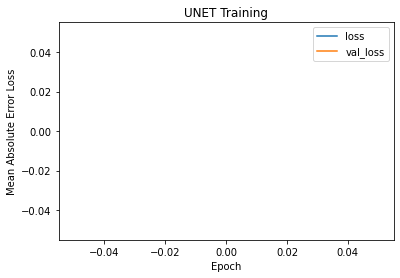

In [52]:
plt.plot(range(len(metrics['loss'])), metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('UNET Training')
# plt.savefig(os.path.join(my_model_results_path,f'UNET_training.png'))
plt.show()

In [ ]:
generator.evaluate(toimage_test_dataset)

4/4 [==============================] - 4s 410ms/step - loss: 0.1761 - accuracy: 0.4549


[0.17605410516262054, 0.45490431785583496]

### View

In [53]:
generator = UNet()
generator.compile(loss=tf.losses.mean_absolute_error)

version = 10
my_model_save_path_v = my_model_save_path[:-4] + f'{version}.h5'
classifier_save_path_v = classifier_save_path[:-4] + f'{version}_UNET30.h5'

# generator.load_weights(classifier_save_path_v, by_name=True)
generator.load_weights(my_model_save_path_v, by_name=True)

/content/drive/MyDrive/CSC5218_Project_DL/saved models/Autoencoder/Autoencoder_1/Autoencoder_30.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


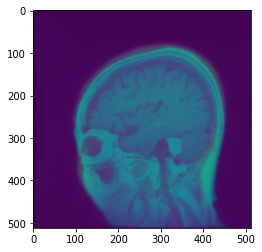

In [55]:
version = 30
my_model_save_path_v = my_model_save_path[:-4] + f'{version}.h5'
print(my_model_save_path_v)
generator.load_weights(my_model_save_path_v, by_name=True)

gen_output = generator(inp[tf.newaxis, ...]/255, training=False)
plt.imshow(gen_output[0, ...])
plt.savefig(os.path.join(my_model_results_path,f'UNET_{version}.png'))
plt.show()

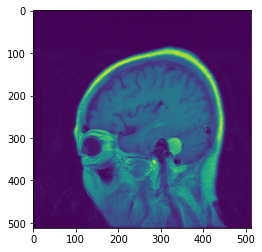

In [56]:
plt.imshow(inp/255)
# plt.savefig(os.path.join(my_model_results_path,f'ground_truth.png'))

# Just Right

In [57]:
def UNet2():
  inputs = tf.keras.layers.Input(shape=[512, 512, 3], name='input')
  l = tf.keras.layers.Conv2D(1, 1, padding='same', use_bias=False, name='location')
  l.trainable = False
  l = l(inputs)
  x = tf.keras.layers.concatenate([inputs,l], name='concat')
  x = tf.keras.layers.Conv2D(3,3, padding='same', name='colorer')(x)
  
  return tf.keras.Model(inputs=inputs, outputs=x)

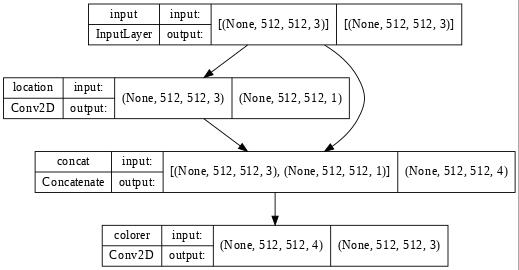

In [ ]:
generator2 = UNet2()
just_right_architecture_path = os.path.join(results_folder_path,'right_architecture.jpg')
tf.keras.utils.plot_model(generator2, show_shapes=True, dpi=64, show_layer_names=True,rankdir='TB', to_file=just_right_architecture_path)
# tf.keras.utils.plot_model(generator2, show_shapes=True, dpi=64, show_layer_names=True)

In [58]:
generator2.load_weights(my_model_save_path, by_name=True)
# generator2.load_weights(classifier_save_path, by_name=True)

NameError: ignored

In [ ]:
version = 30
my_model_save_path_v = my_model_save_path[:-4] + f'{version}.h5'
print(my_model_save_path_v)
generator2.load_weights(my_model_save_path_v, by_name=True)

gen_output = generator2(inp[tf.newaxis, ...]/255, training=False)
plt.imshow(gen_output[0, ...]*255)
print(gen_output[0, ...])
# plt.savefig(os.path.join(my_model_results_path,f'right_UNET_{version}.png'))
plt.show()

# Just Left

In [ ]:
def UNet3():
  inputs = tf.keras.layers.Input(shape=[512, 512, 3], name='input')

  down_stack = [
    downsample(64, 4, apply_batchnorm=False, name='down_1'), # (batch_size, 256, 256, 64)
    downsample(128, 4, name='down_2'), # (batch_size, 128, 128, 128)
    downsample(256, 4, name='down_3'), # (batch_size, 64, 64, 256)
    downsample(512, 4, name='down_4'), # (batch_size, 32, 32, 512)
    downsample(512, 4, name='down_5'), # (batch_size, 16, 16, 512)
    downsample(512, 4, name='down_6'), # (batch_size, 8, 8, 512)
    downsample(512, 4, name='down_7'), # (batch_size, 4, 4, 512)
    downsample(512, 4, name='down_8'), # (batch_size, 2, 2, 512)
    downsample(512, 4, name='down_9'), # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True, name='up_1'), # (batck_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True, name='up_2'), # (batck_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True, name='up_3'), # (batck_size, 8, 8, 1024)
    upsample(512, 4, name='up_4'), # (batck_size, 16, 16, 1024)
    upsample(256, 4, name='up_5'), # (batck_size, 32, 32, 512)
    upsample(128, 4, name='up_6'), # (batck_size, 64, 64, 256)
    upsample(64, 4, name='up_7'), # (batck_size, 128, 128, 128)
    upsample(32, 4, name='up_8'), # (batck_size, 256, 256, 64)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)

  last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='tanh', name='last') # (batch_size, 512, 512, 3)
  last.trainable = False

  x = inputs

  # Downsampling through the model
  l = tf.keras.layers.Conv2D(1, 1, padding='same',
                              kernel_initializer=initializer, use_bias=False, name='rand')
  l.trainable = False
  l = l(x)
  for down in down_stack:
    x = down(x)
  
  layer = tf.keras.Sequential([tf.keras.layers.Dense(512)], name='latent')
  x = layer(x)

  # Upsampling and establishing the skip connection
  i = 0
  for up in up_stack:
    x = up(x)
    i += 1

  x = last(x)
  x = tf.keras.layers.Concatenate(name='concat')([x, l])
  x = tf.keras.layers.Conv2D(3, 3, name='colorer', padding='same')(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator3 = UNet3()
just_left_architecture_path = os.path.join(results_folder_path,'left_architecture.jpg')
tf.keras.utils.plot_model(generator3, show_shapes=True, dpi=64, show_layer_names=True,rankdir='TB', to_file=just_left_architecture_path)

In [ ]:
generator3.load_weights(my_model_save_path, by_name=True)
# generator3.load_weights(classifier_save_path, by_name=True)

/content/drive/MyDrive/CSC5218_Project_DL/saved models/Autoencoder/Autoencoder_1/Autoencoder_30.h5


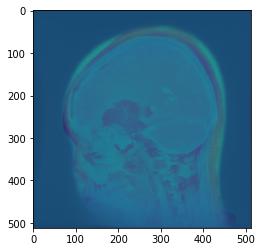

In [ ]:
version = 30
my_model_save_path_v = my_model_save_path[:-4] + f'{version}.h5'
print(my_model_save_path_v)
generator3.load_weights(my_model_save_path_v, by_name=True)

gen_output = generator3(inp[tf.newaxis, ...]/255, training=False)
plt.imshow(gen_output[0, ...])
plt.savefig(os.path.join(my_model_results_path,f'left_UNET_{version}.png'))
plt.show()

# CNN

In [59]:
def CNN():
  inputs = tf.keras.layers.Input(shape=[512, 512, 3], name='input')

  down_stack = [
    downsample(64, 4, apply_batchnorm=False, name='class_down_1'), # (batch_size, 256, 256, 64)
    downsample(128, 4, name='class_down_2'), # (batch_size, 128, 128, 128)
    downsample(256, 4, name='class_down_3'), # (batch_size, 64, 64, 256)
    downsample(512, 4, name='class_down_4'), # (batch_size, 32, 32, 512)
    downsample(512, 4, name='class_down_5'), # (batch_size, 16, 16, 512)
    downsample(512, 4, name='class_down_6'), # (batch_size, 8, 8, 512)
    downsample(512, 4, name='class_down_7'), # (batch_size, 4, 4, 512)
    downsample(512, 4, name='class_down_8'), # (batch_size, 2, 2, 512)
    downsample(512, 4, name='class_down_9'), # (batch_size, 1, 1, 512)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)

  last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='tanh') # (batch_size, 512, 512, 3)

  x = inputs

  for down in down_stack:
    x = down(x)

  layer = tf.keras.Sequential([tf.keras.layers.Dense(512, activation='relu')], name='latent')
  x = layer(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(3)(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
classifier = CNN()
classifier_architecture_path = os.path.join(results_folder_path,'classifier_architecture.jpg')
tf.keras.utils.plot_model(classifier, show_shapes=True, dpi=64, show_layer_names=True,rankdir='TB', to_file=classifier_architecture_path)

In [ ]:
classifier.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

## Train

In [ ]:
modelcheckpointpath = os.path.join(models_folder_path,'classifier_chkpts')
checkpoint = tf.keras.callbacks.ModelCheckpoint(modelcheckpointpath, save_best_only=True, save_weights_only=True)

In [ ]:
class_histories = []
epochs = 20
for i in range(1,7):
  version = i*epochs + 80
  history = classifier.fit(x=class_train_dataset, validation_data=class_validation_dataset, epochs=epochs, callbacks=checkpoint)
  class_histories.append(history)
  classifier_save_path_v = classifier_save_path[:-4] + f'{version}_UNET30.h5'
  print(classifier_save_path_v)
  classifier.save(classifier_save_path_v)

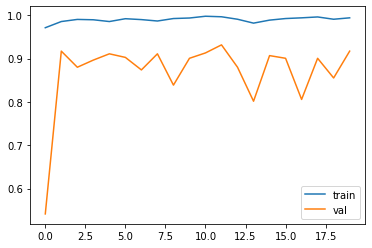

In [ ]:
plt.plot(class_histories[0].history['accuracy'], label='train')
plt.plot(class_histories[0].history['val_accuracy'], label='val')
plt.legend()
plt.show()

## Load

In [ ]:
# version = 80
# classifier_save_path_v = classifier_save_path[:-4] + f'{version}_UNET30.h5'
# classifier.load_weights(classifier_save_path_v, by_name=True)

## Evaluate

In [ ]:
# tf.config.run_functions_eagerly(True)
metrics = classifier.evaluate(class_test_dataset)

4/4 [==============================] - 4s 317ms/step - loss: 0.1456 - accuracy: 0.9375


In [ ]:
labels = []
predictions = []
for image_batch,label_batch in iter(class_test_dataset):
  for label in label_batch:
    labels.append(np.argmax(label.numpy()))
    # print(label.numpy())

  # prediction = classifier.predict(image_batch, batch_size=32)
  # print(prediction)
  for image in image_batch:
    prediction = classifier.predict(image[tf.newaxis, ...])
    predictions.append(np.argmax(prediction))

In [ ]:
conf = tf.math.confusion_matrix(labels,predictions)
conf

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[47,  7,  1],
       [ 4, 33,  0],
       [ 0,  0, 36]], dtype=int32)>

Text(0.5, 1.05, 'Classifier Epoch 160 Confution Matrix')

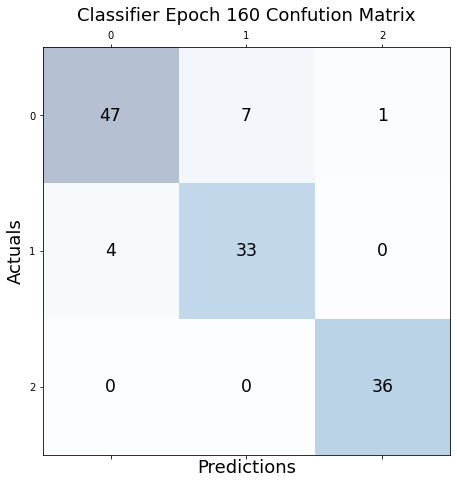

In [ ]:
labels = np.array(conf)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf, cmap=plt.cm.Blues, alpha=0.3)
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        ax.text(x=j, y=i,s=labels[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title(f'Classifier Epoch {version} Confution Matrix', fontsize=18)
# plt.savefig(os.path.join(my_model_results_path,f'conf_class_{version}.png'))

# Combined models

In [60]:
def UNet_CNN():
  inputs = tf.keras.layers.Input(shape=[512, 512, 3], name='input1')

  down_stack = [
    downsample(64, 4, apply_batchnorm=False, name='class_down_1'), # (batch_size, 256, 256, 64)
    downsample(128, 4, name='class_down_2'), # (batch_size, 128, 128, 128)
    downsample(256, 4, name='class_down_3'), # (batch_size, 64, 64, 256)
    downsample(512, 4, name='class_down_4'), # (batch_size, 32, 32, 512)
    downsample(512, 4, name='class_down_5'), # (batch_size, 16, 16, 512)
    downsample(512, 4, name='class_down_6'), # (batch_size, 8, 8, 512)
    downsample(512, 4, name='class_down_7'), # (batch_size, 4, 4, 512)
    downsample(512, 4, name='class_down_8'), # (batch_size, 2, 2, 512)
    downsample(512, 4, name='class_down_9'), # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True, name='up_1'), # (batck_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True, name='up_2'), # (batck_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True, name='up_3'), # (batck_size, 8, 8, 1024)
    upsample(512, 4, name='up_4'), # (batck_size, 16, 16, 1024)
    upsample(256, 4, name='up_5'), # (batck_size, 32, 32, 512)
    upsample(128, 4, name='up_6'), # (batck_size, 64, 64, 256)
    upsample(64, 4, name='up_7'), # (batck_size, 128, 128, 128)
    upsample(32, 4, name='up_8'), # (batck_size, 256, 256, 64)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)

  last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='tanh', name='last') # (batch_size, 512, 512, 3)
  last.trainable = False

  x = inputs

  l = tf.keras.layers.Conv2D(1, 1, padding='same',
                              kernel_initializer=initializer, use_bias=False, name='location')
  l.trainable = False
  l = l(inputs)

  # Downsampling through the model
  for down in down_stack:
    x = down(x)

  # Latent
  layer = tf.keras.Sequential([tf.keras.layers.Dense(512, activation='relu')], name='latent')
  x = layer(x)

  # Upsampling and establishing the skip connection
  i = 0
  for up in up_stack:
    x = up(x)
    i += 1

  x = last(x)
  x = tf.keras.layers.Concatenate(name='concat')([x, l])
  x = tf.keras.layers.Conv2D(3, 3, name='colorer', padding='same')(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [70]:
final_generator = UNet_CNN()
final_architecture_path = os.path.join(results_folder_path,'final_unet_architecture.jpg')
# tf.keras.utils.plot_model(final_generator, show_shapes=True, dpi=64, show_layer_names=True, expand_nested=False, to_file=final_architecture_path)

In [71]:
version2 = 30
my_model_save_path_v = my_model_save_path[:-4] + f'{version2}.h5'
final_generator.load_weights(my_model_save_path_v, by_name=True)

In [72]:
print(final_generator.get_weights()[6][:10,0,0,0])
print(final_generator.get_weights()[-1])

[-0.00516959 -0.00633577  0.02307743  0.04570845]
[0.13716376 0.09172163 0.22535145]


In [73]:
version = 140
classifier = CNN()
classifier_save_path_v = classifier_save_path[:-4] + f'{version}_UNET30.h5'
classifier.load_weights(classifier_save_path_v, by_name=True)
print(classifier.get_weights()[6][:10,0,0,0])
temp = []
for layer_class in classifier.layers:
  for layer_unet in final_generator.layers:
    # print(layer_class.name, layer_unet.name)
    if layer_class.name == layer_unet.name:
      # print(layer_class.name)
      layer_unet.set_weights(layer_class.weights)

[0.07504298 0.01413532 0.01610822 0.00811908]


In [74]:
print(final_generator.get_weights()[6][:10,0,0,0])
print(final_generator.get_weights()[-1])

[0.07504298 0.01413532 0.01610822 0.00811908]
[0.13716376 0.09172163 0.22535145]


In [75]:
version = 30
my_model_save_path_v = my_model_save_path[:-4] + f'{version}.h5'
print(my_model_save_path_v)
generator.load_weights(my_model_save_path_v, by_name=True)

/content/drive/MyDrive/CSC5218_Project_DL/saved models/Autoencoder/Autoencoder_1/Autoencoder_30.h5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


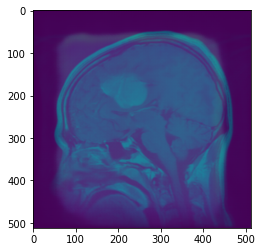

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


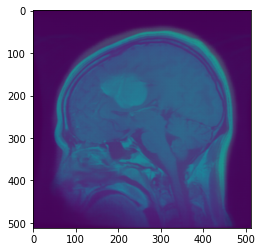

In [106]:
inp,lab = next(iter(test_ds))
inp = inp[0]
gen_output = final_generator(inp[tf.newaxis, ...]/255, training=False)
plt.imshow(gen_output[0, ...])
# plt.savefig(os.path.join(my_model_results_path,f'UNETCNN_{version}.png'))
plt.show()
gen1_output = generator(inp[tf.newaxis, ...]/255, training=False)
plt.imshow(gen1_output[0, ...])
plt.show()

# CNN Saliency Map

tf.Tensor(1, shape=(), dtype=int32)
[0] [[-4.6151633 -5.7457924 -6.1769624]]


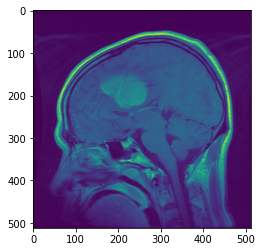

In [107]:
# batch =next(iter(test_ds))
# img = np.array(batch[0])[0]
# label = batch[1][0]
print(lab[0])
# plt.title(f'{lab[0]}')
plt.imshow(inp/255)
class_output = classifier.predict(inp[tf.newaxis, ...]/255)
y_class = class_output.argmax(axis=-1) 
print(y_class, class_output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


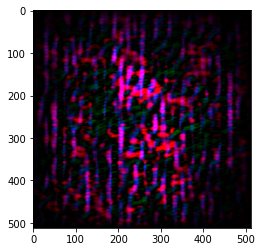

In [108]:
# batch = next(iter(class_test_dataset))
# img = batch[0][0]
# print(img.shape)
# label = batch[1][0]
images = tf.Variable(inp[tf.newaxis, ...]/255, dtype=float)

predA = classifier.predict(inp[tf.newaxis, ...]/255)
with tf.GradientTape() as tape:
    pred = classifier(images, training=False)
    class_idx = np.argmax(pred.numpy())
    loss = pred[0][class_idx]
    
# print(predA, pred)
# print(class_idx, loss)
grads = tape.gradient(loss, images)
norm1 = grads / np.linalg.norm(grads)
# print('ave',np.average(grads, axis=3))
# print('ave',np.average(norm1, axis=3))
plt.imshow(norm1[0]*255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


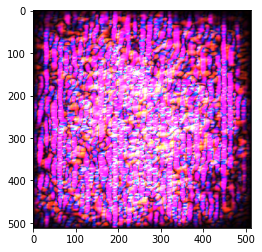

In [109]:
dgrad_abs = tf.math.abs(grads)
plt.imshow(dgrad_abs[0]*255)

In [110]:
dgrad_max_ = np.max(grads, axis=3)[0]

In [111]:
## normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

tf.Tensor([-4.6151643 -5.7457924 -6.176963 ], shape=(3,), dtype=float32)
tf.Tensor(1, shape=(), dtype=int32)


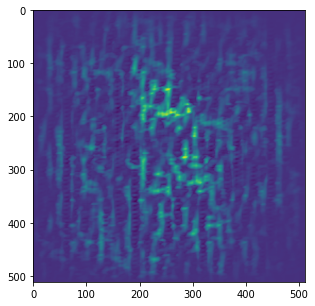

In [112]:
print(pred[0])
print(lab[0])
fig, axes = plt.subplots(1,1,figsize=(10,5))
# axes.imshow(inp/255)
axes.imshow(grad_eval)
# fig.colorbar(i)

In [113]:
grad_map = np.ones((512,512,3))
for x in range(len(grad_eval)):
  for y in range(len(grad_eval[0])):
    grad_map[x,y] = [grad_eval[x,y],grad_eval[x,y],grad_eval[x,y]]

In [114]:
combined = grad_map + inp.numpy()/255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


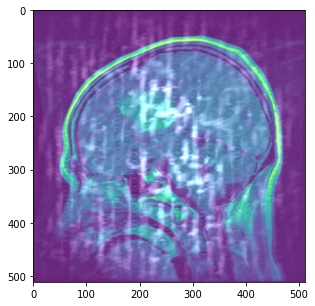

In [115]:
fig, axes = plt.subplots(1,1,figsize=(5,5))
axes.imshow(combined)